In [ ]:
import torch
import numpy as np
import torch  # https://pytorch.org
from typing import *
import matplotlib.pyplot as plt
import skimage

In [ ]:
import random
def gen_img():
    return torch.rand(400,400,3)

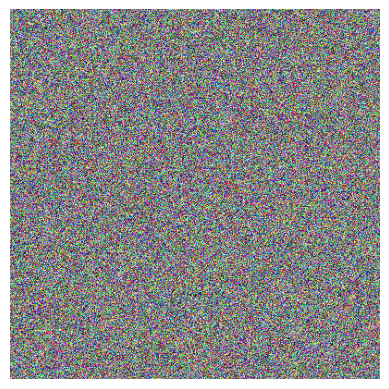

In [ ]:
%matplotlib inline

plt.imshow(gen_img())
plt.axis('off')
plt.show()

In [ ]:
from functools import reduce
def tot_chans(img):
    return reduce(lambda x,y: x*y, img.shape)

In [ ]:
def noise_like(st: torch.Tensor):
    """Generates normally distributed noise shaped like `st`."""
    return torch.randn(st.shape).to("cuda")

In [ ]:
def disp_img(im):
    if im.shape[2] != 3:
        im = torch.moveaxis(im,0,2)
    plt.imshow(im)
    plt.axis('off')
    plt.show()

(3, 256, 256)


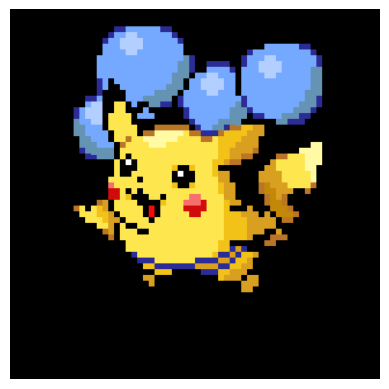

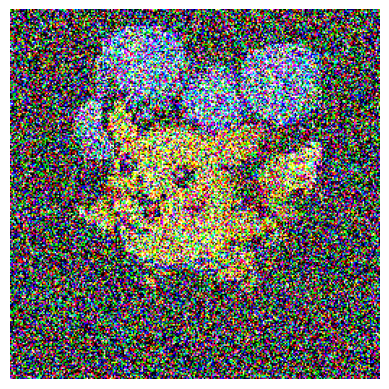

In [ ]:
pika_img = skimage.io.imread("./pikachu.png")
pika_img = np.moveaxis(pika_img,2,0)
pika_img = np.delete(pika_img, 3, axis=0)
print(pika_img.shape)
pika_img = torch.tensor(pika_img).to('cuda')
pika_img = pika_img.float() / 255
noise = noise_like(pika_img).to('cuda')
disp_img(pika_img.cpu())
disp_img((pika_img+noise).cpu())

In [ ]:
from torch_unet import UNet

In [ ]:
x = torch.nn.ConvTranspose2d(in_channels=1024,out_channels=512, stride=2, kernel_size=2)
x(torch.rand(1024,4,4)).shape

torch.Size([512, 8, 8])

In [ ]:
u = UNet(in_channels=3, out_channels=3)
u = u.to('cuda')

In [ ]:
pika_img.to('cuda')
u(torch.stack([pika_img.to('cuda') for _ in range(5)],dim=0)).shape

torch.Size([5, 3, 256, 256])

In [ ]:
# Download thumbnails from URLs of the form: https://raw.githubusercontent.com/HybridShivam/Pokemon/master/assets/thumbnails/xxx.png
# where xxx ranges from 001 to 905

# Load them into memory and convert them to (156,156,3) tensors using scikit-image

from skimage import io
import requests
from io import BytesIO
import jax.numpy as jnp

from functools import cache

@cache
def img_to_tensor(url):
  response = requests.get(url)
  img_bytes = BytesIO(response.content)
  img_array = io.imread(img_bytes)
  img_tensor = np.swapaxes(img_array, 0, 2)
  img_tensor = np.delete(img_tensor, 3, axis=0)
  return img_tensor

def download_images():
  url_format = "https://raw.githubusercontent.com/HybridShivam/Pokemon/master/assets/thumbnails/{:03d}.png"

  # Initialize empty list for storing images
  images = []

  # Loop through all IDs from 001 to 905
  for i in range(1, 906):
      # Construct the URL for the current ID
      url = url_format.format(i)

      # Download the image from the URL
      image = img_to_tensor(url)

      # convert from 0-255 int RGB to 0-1 float RGB
      image = image.astype(float) / 255

      # Append the image to the list
      images.append(image)
  return images

In [ ]:
import os
import pickle
if os.path.exists("./images.pkl"):
    with open("./images.pkl", "rb") as p:
        images = pickle.load(p)
else:
    images = download_images()
    with open("./images.pkl", "wb") as p:
        pickle.dump(images,p)


In [ ]:
# rotate each image in images by -pi/2
for i in range(len(images)):
    images[i] = np.rot90(images[i], k=-1, axes=(1, 2))

In [ ]:
images = [torch.tensor(a.copy()) for a in images]

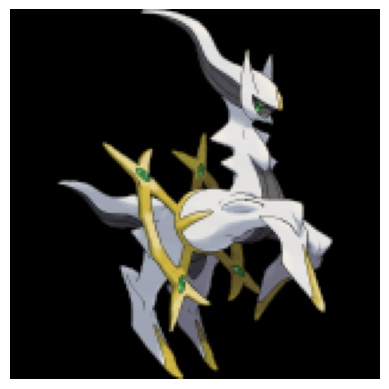

In [ ]:
disp_img(images[492])

In [ ]:
images = filter(lambda x: x.shape[1] == 156 and x.shape[2] == 156, images)
images = list(images)

In [ ]:
def loss(model, noised, og):
    pred_noise = model(noised)
    real_noise = noised-og
    return ((pred_noise-real_noise)**2).mean()

In [ ]:
# tfd distribution that returns a random entry from images
class ImageDist(torch.distributions.Distribution):
    def __init__(self, images):
        self.images = images

    def sample(self, size=1):
      return torch.stack([self.images[random.randrange(0,len(self.images))] for _ in range(size)], axis=0)

In [ ]:
d = ImageDist(images)
d.sample(10).shape

torch.Size([10, 3, 156, 156])

In [ ]:
import math

In [ ]:
default_noising_schedule = torch.tensor(np.linspace(.0001,.02,1000))

In [ ]:
def alpha_bar(t,noising_schedule):
  return reduce(lambda x,y: x*y,[1 - beta for beta in noising_schedule[:t+1]])

In [ ]:
def add_noise(img, t, noising_schedule):
  return math.sqrt(alpha_bar(t,noising_schedule)) * img + math.sqrt(1 - alpha_bar(t,noising_schedule)) * noise_like(img)

In [ ]:
import torch.optim as optim
def train(model, steps, batch_size, print_every: int, training_dist, noising_schedule):
  # Define the loss function and optimizer
  opt = optim.Adam(model.parameters(), lr=0.001)

  max_temp = len(noising_schedule)
  temp_dist = torch.tensor(range(0,max_temp))

  def alpha_bar(t):
    return alpha_bar(t, noising_schedule)
  def noised(img, t):
    return add_noise(img, t, noising_schedule)

  def make_step(epoch):
      t = random.choice(temp_dist)
      batch = training_dist.sample(size=batch_size).to('cuda')
      L = loss(model, noised(batch,t), batch)
      opt.zero_grad()
      L.backward()

      opt.step()
      print(f"{epoch+1}/{steps}: {L.item():.5f}")

  for epoch in range(steps):
    make_step(epoch)
  return model

In [ ]:
images = [i.to('cuda', dtype=torch.float32) for i in images]

In [ ]:
def pad_to_shape(x, target_shape):
    p = [0] * (2 * len(target_shape))
    for i, s in enumerate(target_shape):
        p[2 * (len(target_shape) - 1 - i) + 1] = s - x.size(i)
    return torch.nn.functional.pad(x, p)

In [ ]:
images = torch.stack([pad_to_shape(i, (3,156,156)) for i in images], dim=0)

In [ ]:
if os.path.exists("./denoising_model.pt"):
    u = torch.serialization.load("denoising_model.pt", map_location="cuda")
else:
    train(u, 1000, 50, 1, ImageDist(images), default_noising_schedule)

In [ ]:
u = train(u,100000,128,1,ImageDist(images), default_noising_schedule)

Streaming output truncated to the last 5000 lines.
9071/100000: 0.00288
9072/100000: 0.01966
9073/100000: 0.03475
9074/100000: 0.05926
9075/100000: 0.00767
9076/100000: 0.00663
9077/100000: 0.03597
9078/100000: 0.06277
9079/100000: 0.02967
9080/100000: 0.07716
9081/100000: 0.01162
9082/100000: 0.00794
9083/100000: 0.00346
9084/100000: 0.06670
9085/100000: 0.00140
9086/100000: 0.06745
9087/100000: 0.00542
9088/100000: 0.01534
9089/100000: 0.00712
9090/100000: 0.01334
9091/100000: 0.00106
9092/100000: 0.07479
9093/100000: 0.00929
9094/100000: 0.00320
9095/100000: 0.07486
9096/100000: 0.04011
9097/100000: 0.00237
9098/100000: 0.06704
9099/100000: 0.06136
9100/100000: 0.07347
9101/100000: 0.01523
9102/100000: 0.01890
9103/100000: 0.06867
9104/100000: 0.00176
9105/100000: 0.01241
9106/100000: 0.00534
9107/100000: 0.04198
9108/100000: 0.06504
9109/100000: 0.07967
9110/100000: 0.00750
9111/100000: 0.06665
9112/100000: 0.00210
9113/100000: 0.00429
9114/100000: 0.06326
9115/100000: 0.01578
9116

In [ ]:
torch.serialization.save(u, "denoising_model.pt")

In [ ]:
def denoise(model, img, gas):
  img = torch.stack([img],dim=0)
  for _ in range(gas):
    img = img - model(img)
  return img

In [ ]:
def sample(model, schedule, limit=None):
  if limit is None:
    limit = len(schedule)
  def stacked(a):
    return torch.stack([a], dim=0)
  def alpha(t):
    return 1 - schedule[t-1]
  x = stacked(noise_like(images[0]))
  for t in reversed(range(1,limit+1)):
    real_t = len(schedule)-limit+t
    # z = 0 if t == 1 else stacked(noise_like(images[1]))
    noise_scale = (1 - alpha(real_t))/(torch.sqrt(alpha_bar(real_t,schedule)))
    new_x = (1/torch.sqrt(alpha(real_t))) * (x - noise_scale*model(x))
    del x
    x = new_x
  return x

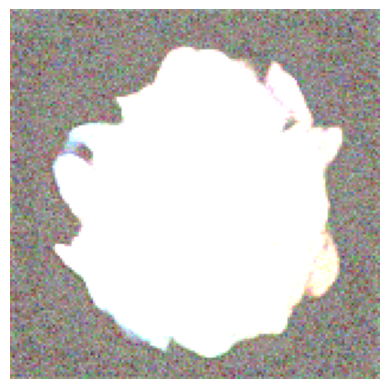

In [ ]:
disp_denoised(sample(u, default_noising_schedule, limit=3))

In [ ]:
def disp_denoised(img):
    disp_img(img.reshape(*images[0].shape).detach().cpu())

In [ ]:
torch.mps.empty_cache()

In [ ]:
noise = noise_like(images[1])
denoised = denoise(u, noise, 2)
disp_denoised(denoised)

In [ ]:
# denoised = denoise(u, noise, 15)
# disp_denoised(denoised)

In [ ]:
disp_img(add_noise(images[0], 100, default_noising_schedule).cpu())

In [ ]:
disp_denoised(denoise(u, add_noise(images[0],100,default_noising_schedule),4))

In [ ]:
model()

In [ ]:
key = jax.random.PRNGKey(0)
model = train(model,optim,1000,0,ImageDist(images),jnp.linspace(0.0001,.02,1000), key)

In [ ]:
disp_img(images[0])

In [ ]:
bulbasaur = images[0]
bulbasaur.shape

In [ ]:
disp_img(noise_like(bulbasaur, jax.random.PRNGKey(100)))

In [ ]:
noised_bulbasaur = add_noise(images[0], 300, default_noising_schedule, jax.random.PRNGKey(0))
disp_img(noised_bulbasaur)
# disp_img(denoise(model,noised_bulbasaur,500))

In [ ]:
images[0].shape

In [ ]:
disp_img(denoise(model, noised_bulbasaur, 500, key))

In [ ]:
eqx.tree_serialise_leaves("model.eqx", model)

In [ ]:
noised = noise_like(pika_img) + pika_img
disp_img(noised)
disp_img(noised - model(1,noised,key=key))

In [ ]:
loss(model,noised,pika_img,key)